## Real Estate Price Prediction
### Geekbrains AI/BigData Python for Data Science course competition

## Exploratory Data Analysis

In [1]:
import numpy as np 
import pandas as pd 
import datetime

import pylab
from scipy import stats
from scipy.stats import probplot

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from Real_Estate_formulas import reduce_mem_usage, ANOVA, FeatureGenetator, norm_test1, norm_test2, norm_test3

import gc 

In [2]:
matplotlib.rcParams.update({'font.size': 14})  
#plt.style.use('fivethirtyeight')

###  1. Data loading

data source: https://www.kaggle.com/c/realestatepriceprediction/data

#### Data fields
- Id - appartment ID
- DistrictId - district ID
- Rooms - the number of rooms
- Square - appartment area
- LifeSquare - living area
- KitchenSquare - kitchen area
- Floor - floor
- HouseFloor - the number of floors in the building
- HouseYear - the year of completion of the building
- Ecology_1, Ecology_2, Ecology_3 - ecological indicators of the district
- Social_1, Social_2, Social_3 - social indicators of the district
- Healthcare_1, Helthcare_2 - healthcare indicators of the building
- Shops_1, Shops_2 - indicators related to the number of shops, shopping malls in the distrint

In [3]:
path = 'C:/Users/ASER/Desktop/GeekBrains/ML_libraries/kaggle_project/'
df = pd.read_csv(path + 'train.csv')     # training set
X_final = pd.read_csv(path + 'test.csv') # test set

#### Reducing memory usage
Function reduce_mem_usage iterates through all the columns of a dataframe and modifies the data type to reduce memory usage.

In [4]:
df = reduce_mem_usage(df)
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%
Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.21 MB
Decreased by 70.3%


In [5]:
X = df.drop('Price', axis=1)
y = df[['Price']]

#X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('X.shape:', X.shape)
print('X_final.shape', X_final.shape)

gc.collect()  

X.shape: (10000, 19)
X_final.shape (5000, 18)


20

In [6]:
X1 = X.copy()

### 2. Exploratory Data Analysis

### 2.1 Target variable distribution

In [7]:
y_descr = y['Price'].describe().astype(int)
y_descr

count     10000
mean     214138
std       92872
min       59174
25%      153872
50%      192269
75%      249135
max      633233
Name: Price, dtype: int32

In [8]:
range_= y_descr[-1] - y_descr[3]
qtr_1 = y_descr[4]
qtr_3 = y_descr[-2]
IQR = qtr_3 - qtr_1
outliers = qtr_3 + 1.5 * IQR
outliers_set = y[y.Price > outliers]
outliers_frac = round(len(outliers_set) / len(y), 3)

print(f'Mimimum price of the dataset is {y_descr[3]}, maximum price - {y_descr[-1]}')
print('Price range =', range_)
print(f'Median price = {y_descr[5]}, mean = {y_descr[1]}')
print(f'Prices of 75% of the dataset are below {y_descr[-2]}')
print(f'Interquartile range = {round(IQR, 0)}')
print(f'Ourlier prices starts from {round(outliers, 0)}, fraction of outliers in the dataset = {outliers_frac}')

Mimimum price of the dataset is 59174, maximum price - 633233
Price range = 574059
Median price = 192269, mean = 214138
Prices of 75% of the dataset are below 249135
Interquartile range = 95263
Ourlier prices starts from 392030.0, fraction of outliers in the dataset = 0.058


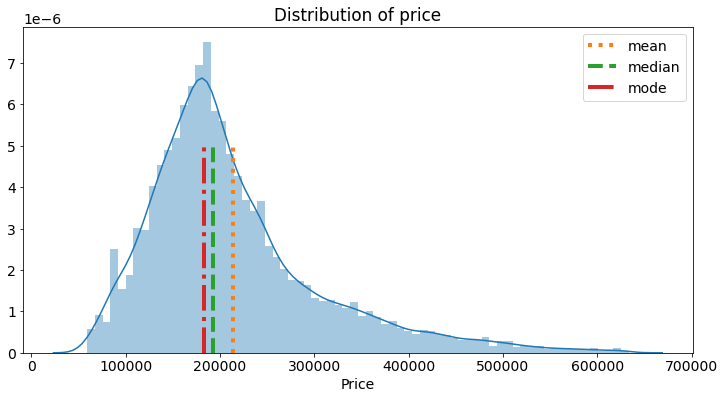

In [9]:
target_mean = y_descr[1]
target_median = y_descr[5]
target_mode = y['Price'].mode()[0]

plt.figure(figsize = (12, 6))

sns.distplot(y['Price'], bins=70)

t = np.linspace(0, 0.000005, 100)
plt.plot([target_mean] * 100, t, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 100, t, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 100, t, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of price')
plt.legend()
plt.show()

#### Q-Q plot for log(price)

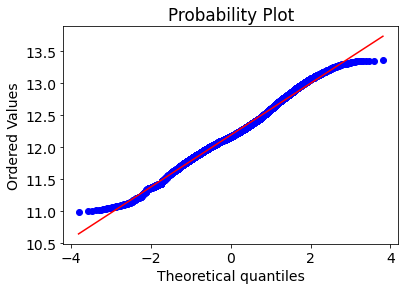

In [10]:
probplot(np.log(y.Price), dist="norm", plot=pylab)
pylab.show()

#### Normal distribution test for np.log(y_train.price)

In [11]:
loc = np.log(y.Price).mean()
scale = np.log(y.Price).std()

for i in range(1, 4):
    true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
    sample_value = ((np.log(y.Price) >= loc - i * scale) \
                    & (np.log(y.Price) <= loc + i * scale)).sum() / y.shape[0]
        
    print(f'{i} sigma(s)')
    print(f'\ttheoretical:\t{true_value}')
    print(f'\tlog(price):\t{sample_value}')

1 sigma(s)
	theoretical:	0.6826894921370859
	log(price):	0.7003
2 sigma(s)
	theoretical:	0.9544997361036416
	log(price):	0.9422
3 sigma(s)
	theoretical:	0.9973002039367398
	log(price):	1.0


### 2.2 Feature analysis

In [12]:
X.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
dtype: object

### A. Numerical variables

In [13]:
X_num_features = X[['HouseYear', 'Square', 'Rooms', 'KitchenSquare', 'LifeSquare', 
                    'Floor', 'HouseFloor']]

round(X_num_features.describe(include="all"), 1)

,HouseYear,Square,Rooms,KitchenSquare,LifeSquare,Floor,HouseFloor
count,10000.0,10000.0,10000.0,10000.0,7887.0,10000.0,10000.0
mean,3990.2,56.3,1.9,6.3,37.2,8.5,12.6
std,200500.3,21.1,0.8,28.6,86.2,5.2,6.8
min,1910.0,1.1,0.0,0.0,0.4,1.0,0.0
25%,1974.0,41.8,1.0,1.0,22.8,4.0,9.0
50%,1977.0,52.5,2.0,6.0,32.8,7.0,13.0
75%,2001.0,65.9,2.0,9.0,45.1,12.0,17.0
max,20052011.0,641.1,19.0,2014.0,7480.6,42.0,117.0


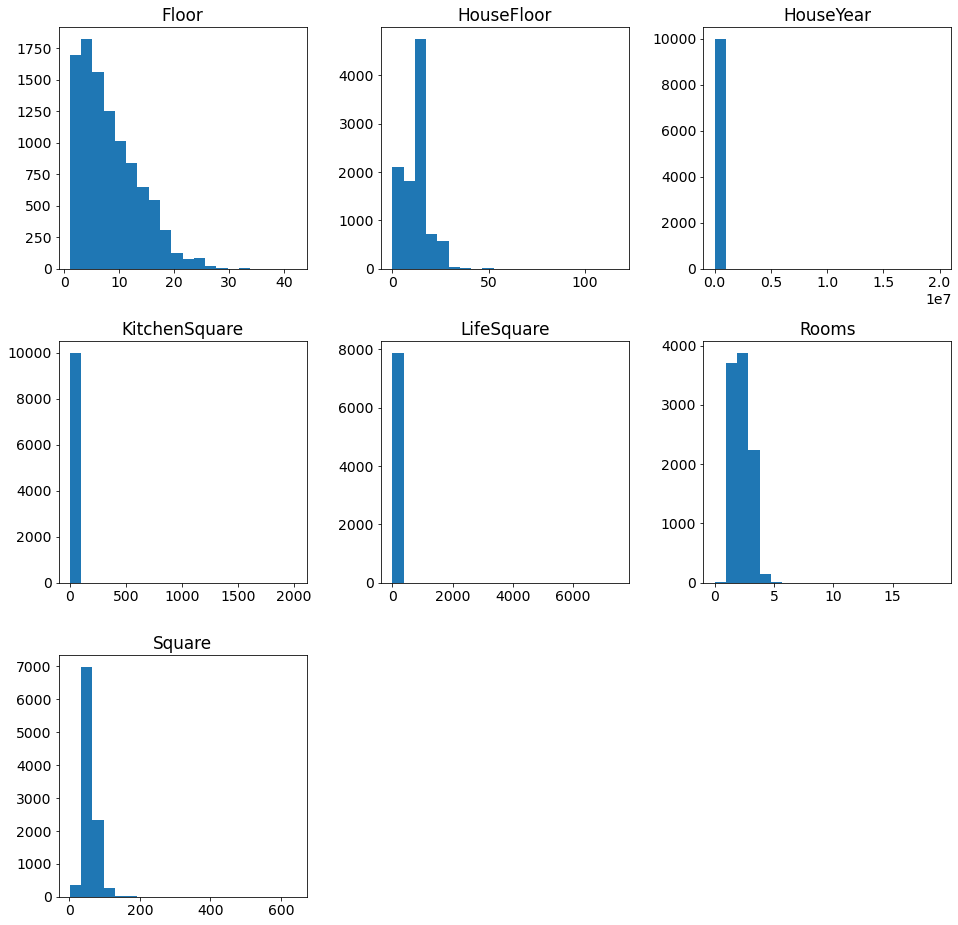

In [14]:
X_num_features.hist(figsize=(16,16), bins=20, grid=False);

### Numeric data preprocessing

#### 1. HouseYear

Fill medians for [DistrictId, KitchenSquare] for HouseYear > 2020

In [15]:
def year_adjustments(X):
    a = X[X.HouseYear > 2020]
    for i in a.index:
        temp = X[(X.DistrictId == a.DistrictId[i]) & (X.KitchenSquare == a.KitchenSquare[i])].HouseYear.median()
        X.loc[i, 'HouseYear'] = np.floor(temp)
    return X

In [16]:
X = year_adjustments(X)

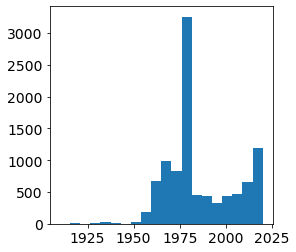

In [17]:
X.loc[X['HouseYear'] < 2050, 'HouseYear'].\
    hist(figsize=(4,4), bins=20, grid=False);

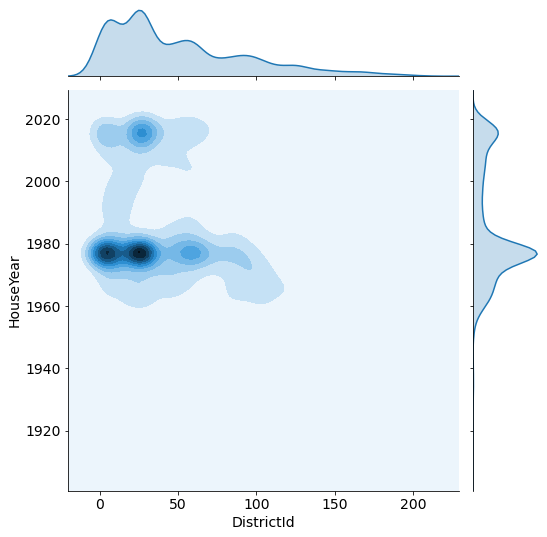

In [18]:
grid = sns.jointplot(X['DistrictId'], X['HouseYear'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

#### 2. Square

For Square < 13:
* if LifeSquare > 13 set Square = LifeSquare
* else set Square = median Square for [DistrictId, HouseYear, Rooms] 

For Square < 250 and Rooms < 4 or KitchenSquare <=10 set Square = Square / 10

In [19]:
def area_adjustments(X):    
    a = X[X.Square < 13]
    for i in a.index:
        if a.LifeSquare[i] > 13:
            X.loc[i,'Square'] = a.LifeSquare[i]
        else:
            temp = X[(X.DistrictId == a.DistrictId[i]) & (X.HouseYear == a.HouseYear[i]) & 
                     (X.Rooms == a.Rooms[i])].Square.median()
            X.loc[i,'Square'] = temp
            
    a = X[((X.Rooms < 4) | (X.KitchenSquare <=10)) & (X.Square > 250)]
    for i in a.index:        
        X.loc[i,'Square'] = a.loc[i, 'Square'] / 10        
    
    return X

In [20]:
X = area_adjustments(X)

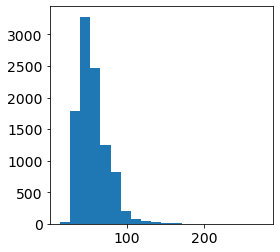

In [21]:
X.loc[X['Square'] > 0, 'Square'].\
    hist(figsize=(4,4), bins=20, grid=False);

#### 3. Rooms

* Fill medians of [DistrictId, Square, HouseYear] for Rooms =0 and Rooms >=5 
* Fill medians of [Square, HouseYear] for Rooms =0 and Rooms >=5 if there is no analogues in the district
* Fill medians of [DistrictId, Square] for Rooms with Square > 200

In [22]:
def rooms_adjustments(X): 
    a = X[((X.Rooms==0) | X.Rooms.isnull()) | ((X.Rooms >= 5) & (X.Square <= 90))]    
    for i in a.index:
        temp = X[(X.DistrictId==a.DistrictId[i]) & 
                 (X.Square > a.Square[i] - 3) & (X.Square < a.Square[i] + 3) &
                 (X.HouseYear == a.HouseYear[i]) & (X.index != i)] 

        X.loc[i,'Rooms'] = temp.Rooms.median()        
    
    a = X[((X.Rooms==0) | X.Rooms.isnull()) | ((X.Rooms >= 5) & (X.Square <= 90))] 
    for i in a.index:
        temp = X[(X.Square > a.Square[i]-3) & (X.Square < a.Square[i]+3) &
                 (X.HouseYear == a.HouseYear[i]) & (X.index != i)]  

        X.loc[i,'Rooms'] = temp.Rooms.median()        
     
    a = X[((X.Rooms==0) | X.Rooms.isnull()) & (X.Square > 200)] 
    for i in a.index:
        temp = X[(X.Square > 200) & (X.DistrictId==a.DistrictId[i]) & (X.index != i)]  

        X.loc[i,'Rooms'] = temp.Rooms.median()        
           
    return X

In [23]:
X = rooms_adjustments(X)

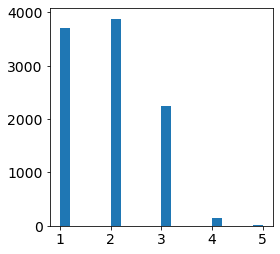

In [24]:
X.loc[X['Rooms'] > 0, 'Rooms'].\
    hist(figsize=(4,4), bins=20, grid=False);

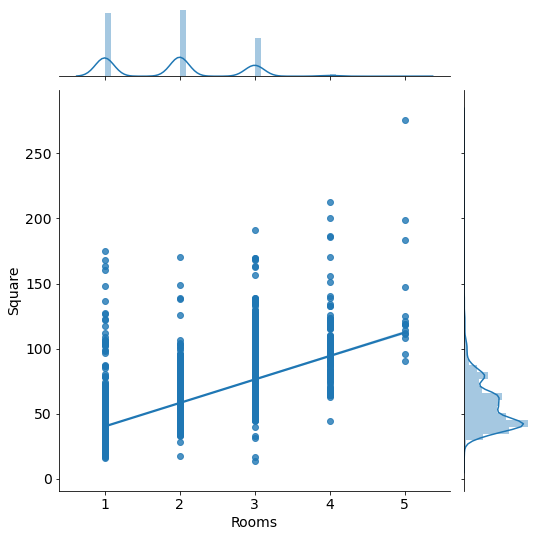

In [25]:
grid = sns.jointplot(X['Rooms'], X['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

#### 4. KitchenSquare

For KitchenSquare < 3 or more than a half of the appartment area: 

* fill KitchenSquare by median KitchenSquare of [DistrictId, HouseYear, Rooms]
* if there is no analogues in the district, fill KitchenSquare by median KitchenSquare of [HouseYear, Rooms]
* if there is no analogues in the district and HouseYear, fill KitchenSquare by median KitchenSquare of Rooms

In [26]:
def kitchen_area_adjustments(X): 
    a = X[(X.KitchenSquare.isnull() | (X.KitchenSquare < 3)) | (X.KitchenSquare > X.Square * 0.5)]
    for i in a.index:
        temp = X[((X.DistrictId == a.DistrictId[i]) & (X.HouseYear == a.HouseYear[i])) &
                 ((X.Rooms == a.Rooms[i]) & (X.KitchenSquare >= 3))].KitchenSquare.median()        
        X.loc[i, 'KitchenSquare'] = temp
    

    a = X[(X.KitchenSquare.isnull() | (X.KitchenSquare < 3)) | (X.KitchenSquare > X.Square * 0.5)]
    for i in a.index:
        temp = X[((X.HouseYear == a.HouseYear[i]) & (X.Rooms == a.Rooms[i])) &
                 (X.KitchenSquare >= 3)].KitchenSquare.median()        
        X.loc[i, 'KitchenSquare'] = temp   
        

    a = X[(X.KitchenSquare.isnull() | (X.KitchenSquare < 3)) | (X.KitchenSquare > X.Square * 0.5)]
    for i in a.index:
        temp = X[(X.Rooms == a.Rooms[i]) & (X.KitchenSquare >= 3)].KitchenSquare.median()        
        X.loc[i, 'KitchenSquare'] = temp 
          
    return X

In [27]:
X = kitchen_area_adjustments(X)

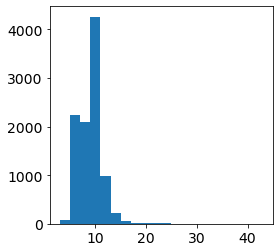

In [28]:
X.loc[X['KitchenSquare'] < 100, 'KitchenSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);

#### 5. LifeSquare

For LifeSquare < 13 or LifeSquare > Square - KitchenSquare or KitchenSquare > 30:
* fill LifeSquare by Square multiplied by median ratio of LifeSquare to Square of [DistrictId, HouseYear, Rooms, Square]
* if there is no analogues in the district, fill LifeSquare by Square multiplied by median ratio of LifeSquare to Square of [HouseYear, Rooms, Square]
* if there is no analogues in the district and HouseYear, fill LifeSquare by Square multiplied by median ratio of LifeSquare to Square of [Rooms, Square]
* if there is no analogues in the district, HouseYear and Rooms fill LifeSquare by Square multiplied by median ratio of LifeSquare to Square for Square.

In [29]:
def living_area_adjustments(X):
    temp = X[(X.LifeSquare > 13) & ((X.Square - X.KitchenSquare) > X.LifeSquare) & 
             (X.KitchenSquare >= 5) & (X.KitchenSquare <= 26)]
    for i in temp.index:
        temp.loc[i, 'weights'] = temp.LifeSquare[i] / temp.Square[i]
        
    a = X[((X.Square < (X.LifeSquare + X.KitchenSquare)) | (X.KitchenSquare > 30)) | 
          (X.LifeSquare.isnull() | (X.LifeSquare < 13))]    
    for i in a.index:    
        median_w = temp[((temp.DistrictId == a.DistrictId[i]) & (temp.Rooms == a.Rooms[i])) &                        
                        (temp.HouseYear == a.HouseYear[i])].weights.median()        
        X.loc[i, 'LifeSquare'] = X.loc[i, 'Square'] * median_w
        
    a = X[((X.Square < (X.LifeSquare + X.KitchenSquare)) | (X.KitchenSquare > 30)) | 
          (X.LifeSquare.isnull() | (X.LifeSquare < 13))]    
    for i in a.index:    
        median_w = temp[(temp.Rooms == a.Rooms[i]) &                        
                        (temp.HouseYear == a.HouseYear[i])].weights.median()        
        X.loc[i, 'LifeSquare'] = X.loc[i, 'Square'] * median_w
 
    a = X[((X.Square < (X.LifeSquare + X.KitchenSquare)) | (X.KitchenSquare > 30)) | 
          (X.LifeSquare.isnull() | (X.LifeSquare < 13))]    
    for i in a.index:    
        median_w = temp[temp.Rooms == a.Rooms[i]].weights.median()        
        X.loc[i, 'LifeSquare'] = X.loc[i, 'Square'] * median_w
    
    return X

In [30]:
X = living_area_adjustments(X)

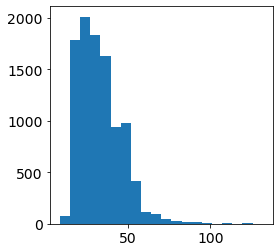

In [31]:
X.loc[X['LifeSquare'] < 200, 'LifeSquare'].\
    hist(figsize=(4,4), bins=20, grid=False);

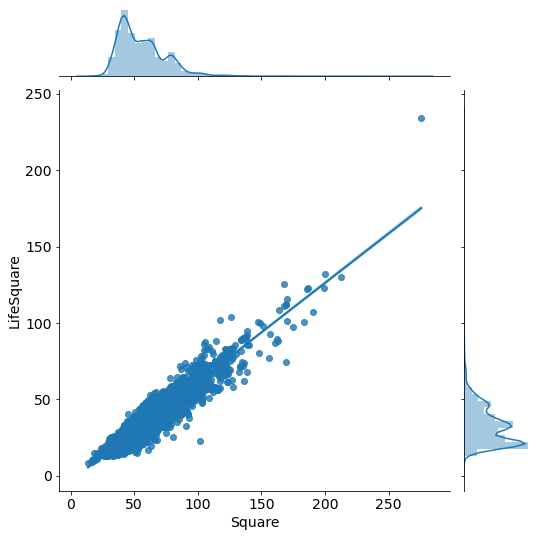

In [32]:
grid = sns.jointplot(X['Square'], X['LifeSquare'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

#### 6. HouseFloor

For HouseFloor = 0 or HouseFloor > 50 or HouseFloor < Floor:
* fill HouseFloor by median HouseFloor of [DistrictId, HouseYear, KitchenSquare]
* if there is no analogues in the district, fill HouseFloor by median HouseFloor of [HouseYear, KitchenSquare]
* if there is no analogues in the district and KitchenSquare, fill HouseFloor by median HouseFloor of HouseYear

In [33]:
def building_floors_adjustments(X): 
    a = X[(X.HouseFloor.isnull() | (X.HouseFloor > 50)) | (X.HouseFloor < X.Floor)]
    for i in a.index:
        temp = X[(((X.DistrictId == a.DistrictId[i]) & (X.HouseYear == a.HouseYear[i])) &
                 (X.KitchenSquare == a.KitchenSquare[i])) &
                 ((X.HouseFloor > 1) & (X.HouseFloor < 50))].HouseFloor.median()   
        if temp < X.Floor[i]:
            temp = X.Floor[i]
        X.loc[i, 'HouseFloor'] = temp        

    a = X[(X.HouseFloor.isnull() | (X.HouseFloor > 50)) | (X.HouseFloor < X.Floor)]
    for i in a.index:
        temp = X[((X.HouseYear == a.HouseYear[i]) & (X.KitchenSquare == a.KitchenSquare[i])) &
                 ((X.HouseFloor > 1) & (X.HouseFloor < 50))].HouseFloor.median()
        if temp < X.Floor[i]:
            temp = X.Floor[i]
        X.loc[i, 'HouseFloor'] = temp        

    a = X[(X.HouseFloor.isnull() | (X.HouseFloor > 50)) | (X.HouseFloor < X.Floor)]
    for i in a.index:
        temp = X[(X.HouseYear == a.HouseYear[i]) & ((X.HouseFloor > 1) & (X.HouseFloor < 50))].HouseFloor.median()
        if temp < X.Floor[i]:
            temp = X.Floor[i]
        X.loc[i, 'HouseFloor'] = temp
        
    return X

In [34]:
X = building_floors_adjustments(X)

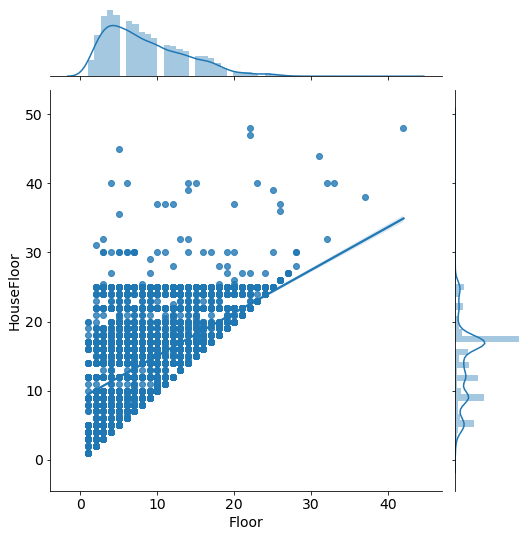

In [35]:
grid = sns.jointplot(X['Floor'], X['HouseFloor'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### Numeric data after preprocessing

In [36]:
X_num_features = X[['HouseYear', 'Square', 'Rooms', 'KitchenSquare', 'LifeSquare', 
                    'Floor', 'HouseFloor']]
round(X_num_features.describe(include="all"), 1)

,HouseYear,Square,Rooms,KitchenSquare,LifeSquare,Floor,HouseFloor
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,1984.9,56.2,1.9,8.7,33.1,8.5,14.1
std,18.4,19.1,0.8,2.6,13.1,5.2,5.6
min,1910.0,13.8,1.0,3.0,8.8,1.0,1.0
25%,1974.0,41.8,1.0,7.0,22.3,4.0,9.0
50%,1977.0,52.5,2.0,9.0,31.5,7.0,16.0
75%,2001.0,65.9,2.0,10.0,40.5,12.0,17.0
max,2020.0,275.6,5.0,43.0,233.9,42.0,48.0


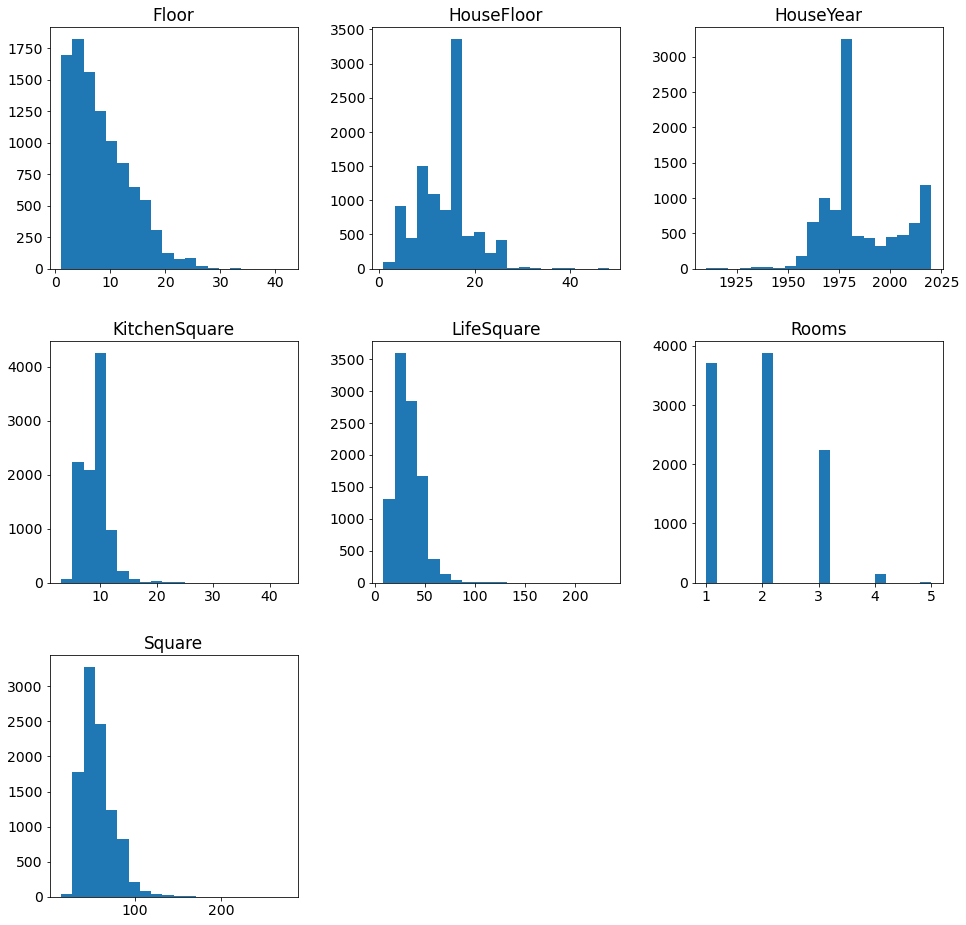

In [37]:
X_num_features.hist(figsize=(16,16), bins=20, grid=False);

#### Correlation matrix

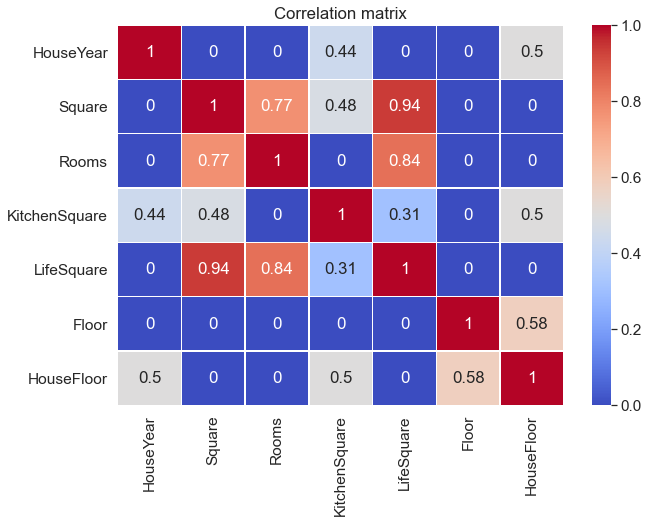

In [38]:
plt.figure(figsize = (10,7))

sns.set(font_scale=1.4)

corr_matrix = X_num_features.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

#### Correlation with the target

In [39]:
var_list = ['HouseYear', 'Square', 'Rooms', 'KitchenSquare', 'LifeSquare', 'Floor', 'HouseFloor']

print('Correlation between log(Price) and target encoded variable:')
for var in var_list:
    corr = np.corrcoef(X[var].fillna(0), np.log(y.Price))[0][1]
    
    if var[:2] in ['Sq', 'Ro', 'Fl'] :
        print(f'{var}:\t\t {round(corr, 3)}')
    else:
        print(f'{var}:\t {round(corr, 3)}')

Correlation between log(Price) and target encoded variable:
HouseYear:	 0.003
Square:		 0.551
Rooms:		 0.57
KitchenSquare:	 0.084
LifeSquare:	 0.574
Floor:		 0.126
HouseFloor:	 0.075


### B Categorical variables

For categorical variables we use a one-way analysis of variance (ANOVA) in order to test for differences in the means of the dependent variable broken down by the levels of the independent variable.

ANOVA requires dependent variable to be normally distributed which is not the case with our dependent variable - Price.

As distribution of log(Price) is more or less close to normal, log(Price) is used in place of Price. We also assume that distributions of log(Price) in groups are homoscedastic and close to normal.

#### 1. DistrictId

In [40]:
df = ANOVA(X, y, 'DistrictId')

nummber of DistrictId = 205
number of cases with no DistrictId specified: 0
number of DistrictId with more than 30 observations = 81
F-test statistic for log(Price) = 51.923, 5% quantile = 1.275
Variance of mean log(Price) by DistrictId is statistically significant


#### Mean prices and number of observations by DistrictId

In [41]:
df.head(10)

,mean_price,n_observations
DistrictId,,
56,318782.12,34
123,314822.81,32
17,313744.40,59
54,304943.86,37
38,297128.54,36
31,297034.20,55
59,295194.11,67
109,292132.81,41
45,289249.14,116


In [42]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
DistrictId,,
27,148574.69,851
1,181468.80,652
23,118792.89,565
6,162533.14,511
9,183246.32,294
62,164322.05,247
30,158649.55,228
58,153308.50,179
53,247626.72,174


#### 2. Social factors: Social_1, Social_2, Social_3
#### Social_1

In [43]:
df = ANOVA(X, y, 'Social_1')

nummber of Social_1 = 51
number of cases with no Social_1 specified: 0
number of Social_1 with more than 30 observations = 46
F-test statistic for log(Price) = 66.7, 5% quantile = 1.371
Variance of mean log(Price) by Social_1 is statistically significant


#### Mean prices and number of observations by Social_1

In [44]:
df.head(10)

,mean_price,n_observations
Social_1,,
32,309248.09,87
20,281022.30,50
15,268102.72,51
17,267753.69,96
14,265389.18,46
18,256386.18,92
50,251835.66,79
46,244716.11,245
37,240229.03,205


In [45]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Social_1,,
2,161290.29,688
1,169723.42,654
25,200454.50,557
5,161711.23,528
30,215568.39,465
23,233167.49,434
6,161947.82,377
22,182412.53,367
53,231518.28,355


#### Social_2

In [46]:
df = ANOVA(X, y, 'Social_2')

nummber of Social_2 = 142
number of cases with no Social_2 specified: 0
number of Social_2 with more than 30 observations = 107
F-test statistic for log(Price) = 47.261, 5% quantile = 1.238
Variance of mean log(Price) by Social_2 is statistically significant


In [47]:
df.head(10)

,mean_price,n_observations
Social_2,,
5027,350201.83,49
6783,345759.61,39
5067,326658.18,32
4635,315694.40,43
7687,308341.36,84
5889,304458.00,62
7077,288984.45,49
5212,285140.31,128
4231,273760.53,32


In [48]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Social_2,,
264,182553.50,587
1564,162533.14,511
629,164454.05,486
1437,155649.41,346
6398,166568.97,245
13670,258373.88,204
5648,178385.54,202
168,96767.67,190
19083,225840.07,176


#### 2. Social_3

In [49]:
df = ANOVA(X, y, 'Social_3')

nummber of Social_3 = 30
number of cases with no Social_3 specified: 0
number of Social_3 with more than 30 observations = 20
F-test statistic for log(Price) = 88.577, 5% quantile = 1.588
Variance of mean log(Price) by Social_3 is statistically significant


#### Mean prices and number of observations by Social_3

In [50]:
df.head(10)

,mean_price,n_observations
Social_3,,
56,288984.45,49
10,275798.23,142
11,259287.44,172
84,253790.74,43
6,252640.79,423
48,249421.60,58
24,246671.20,37
27,245366.00,59
14,244368.85,97


In [51]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Social_3,,
0,167861.46,2997
1,181544.79,1861
3,188122.54,1136
4,230415.85,835
2,224120.61,635
6,252640.79,423
5,243531.78,391
141,166568.97,245
9,226247.28,192


#### 3. Helthcare factors: Helthcare_1, Helthcare_2
#### Healthcare_1

In [52]:
df = ANOVA(X, y, 'Healthcare_1')

nummber of Healthcare_1 = 79
number of cases with no Healthcare_1 specified: 4798
number of Healthcare_1 with more than 30 observations = 60
F-test statistic for log(Price) = 23.679, 5% quantile = 1.324
Variance of mean log(Price) by Healthcare_1 is statistically significant


In [53]:
df.head(10)

,mean_price,n_observations
Healthcare_1,,
46.0,350201.83,49
3300.0,315694.40,43
176.0,308341.36,84
830.0,304458.00,62
2301.0,288984.45,49
1020.0,273760.53,32
520.0,268102.72,51
350.0,264918.84,73
770.0,264357.05,33


In [54]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Healthcare_1,,
540.0,162533.14,511
30.0,184985.14,348
1046.0,166568.97,245
750.0,171205.70,163
229.0,252429.10,148
2300.0,236502.37,142
1084.0,155496.74,137
240.0,201256.13,127
1183.0,188228.42,110


#### Healthcare_2

In [55]:
df = ANOVA(X, y, 'Helthcare_2')

nummber of Helthcare_2 = 7
number of cases with no Helthcare_2 specified: 0
number of Helthcare_2 with more than 30 observations = 7
F-test statistic for log(Price) = 203.671, 5% quantile = 2.1
Variance of mean log(Price) by Helthcare_2 is statistically significant


#### Mean prices and number of observations by Helthcare_2

In [56]:
df.head(10)

,mean_price,n_observations
Helthcare_2,,
5,247290.90,388
4,244267.03,288
1,222530.29,2183
6,221461.36,99
3,214048.56,1670
2,209068.60,1158
0,169216.10,4214


In [57]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Helthcare_2,,
0,169216.10,4214
1,222530.29,2183
3,214048.56,1670
2,209068.60,1158
5,247290.90,388
4,244267.03,288
6,221461.36,99


#### 4. Shops_1

In [58]:
df = ANOVA(X, y, 'Shops_1')

nummber of Shops_1 = 16
number of cases with no Shops_1 specified: 0
number of Shops_1 with more than 30 observations = 16
F-test statistic for log(Price) = 104.143, 5% quantile = 1.667
Variance of mean log(Price) by Shops_1 is statistically significant


#### Mean prices and number of observations by Shops_1

In [59]:
df.head(10)

,mean_price,n_observations
Shops_1,,
19,288984.45,49
10,261257.01,215
11,251804.68,401
7,237275.22,294
3,229499.59,711
9,228772.79,316
6,225985.71,487
15,225840.07,176
8,221000.58,253


In [60]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Shops_1,,
0,158574.07,2316
1,189041.37,1325
5,208584.46,1324
2,190335.17,964
4,206301.88,841
3,229499.59,711
6,225985.71,487
11,251804.68,401
9,228772.79,316


#### 5. Ecology_1

In [61]:
df = ANOVA(X, y, 'Ecology_1')

nummber of Ecology_1 = 129
number of cases with no Ecology_1 specified: 0
number of Ecology_1 with more than 30 observations = 100
F-test statistic for log(Price) = 49.299, 5% quantile = 1.246
Variance of mean log(Price) by Ecology_1 is statistically significant


In [62]:
df.head(10)

,mean_price,n_observations
Ecology_1,,
0.000991,345759.61,39
0.093443,315694.40,43
0.019509,308341.36,84
0.151346,304458.00,62
0.007659,288984.45,49
0.195781,285140.31,128
0.050272,273760.53,32
0.041125,270798.30,89
0.060753,268102.72,51


In [63]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Ecology_1,,
0.007122,182553.50,587
0.000000,253146.54,537
0.243205,162533.14,511
0.072158,164454.05,486
0.075779,155649.41,346
0.000078,166568.97,245
0.069753,258373.88,204
0.161532,178385.54,202
0.034656,96767.67,190


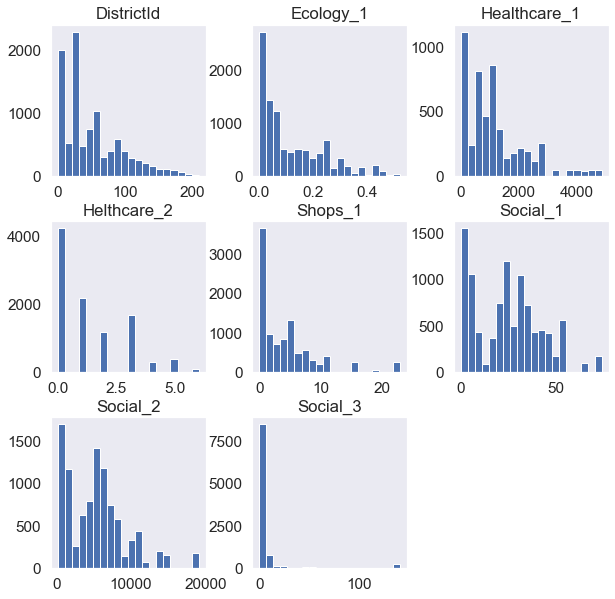

In [64]:
categorical_var = ['DistrictId', 'Social_1', 'Social_2', 'Social_3', 
                   'Healthcare_1','Helthcare_2', 
                   'Shops_1', 'Ecology_1']
X_category_features = X[categorical_var]

X_category_features.hist(figsize=(10,10), bins=20, grid=False);

#### Ecology_1  by DistrictId

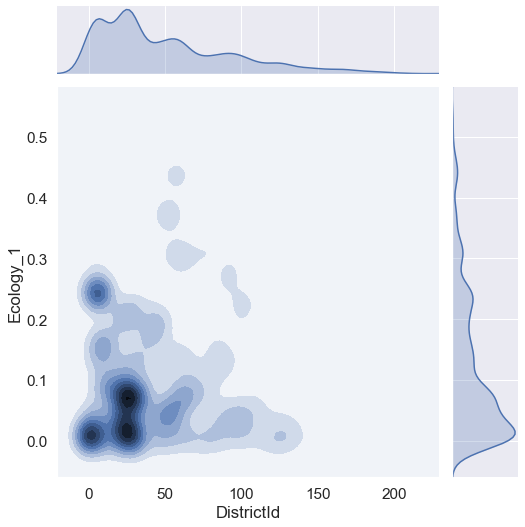

In [65]:
grid = sns.jointplot(X['DistrictId'], X['Ecology_1'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

#### Helthcare_2 by DistrictId 

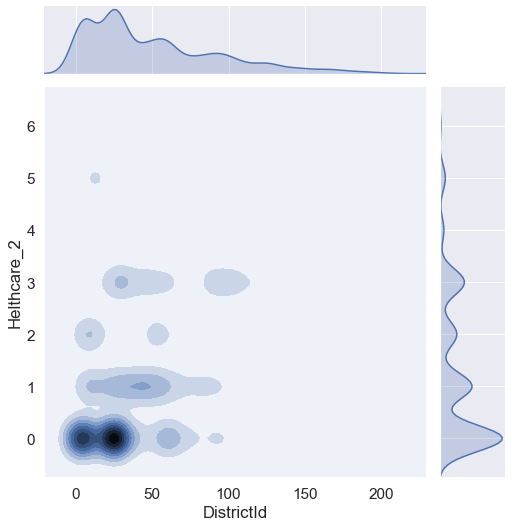

In [66]:
grid = sns.jointplot(X['DistrictId'], X['Helthcare_2'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

#### Social_1 by DistrictId

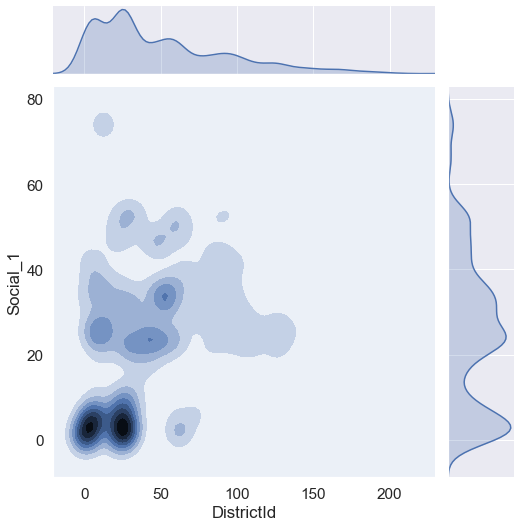

In [67]:
grid = sns.jointplot(X['DistrictId'], X['Social_1'], kind='kde')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

### C Binary variables

In [68]:
binary_variables = ['Ecology_2', 'Ecology_3', 'Shops_2']

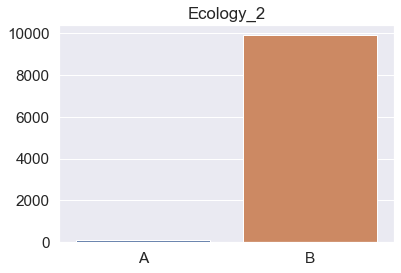

In [69]:
counts = X['Ecology_2'].value_counts()
    
plt.figure(figsize=(6,4))    
plt.title('Ecology_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

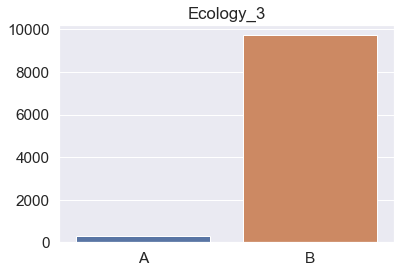

In [70]:
counts = X['Ecology_3'].value_counts()
    
plt.figure(figsize=(6,4))    
plt.title('Ecology_3')
sns.barplot(counts.index, counts.values)
    
plt.show()

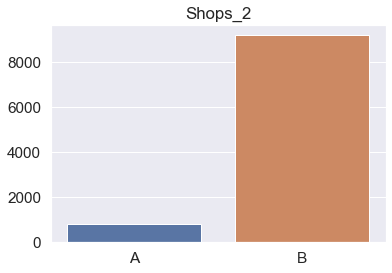

In [71]:
counts = X['Shops_2'].value_counts()
    
plt.figure(figsize=(6,4))    
plt.title('Shops_2')
sns.barplot(counts.index, counts.values)
    
plt.show()

### 3. Data Engineering: FeatureGenetator

The new variables are generated by FeatureGenetator (Real_Estate_formulas.py).
FeatureGenetator performs target encoding of cathegorical variables DistrictID, Ecology_1, Shops_1, Social_1, Social_2, Social_3 and Helthcare_2 and generates new variables with median prices of each level: 
* MedPriceByDistrict,
* MedPriceByEcology_1,
* MedPriceByShops_1,
* MedPriceBySocial_1,
* MedPriceBySocial_2,
* MedPriceBySocial_3,
* MedPriceByHelthcare_2


Each of the variables Floor and HouseYear was split into groups and then jointly target encoded. The new variable - MedPriceByFloorYear.

The above variables together with Square, LifeSquare, Rooms, KitchenSquare and HouseYear were used in principal component analysis to generate 4 new composit variables:
* pca_composit_1, 
* pca_composit_2, 
* pca_composit_3,
* pca_composit_4.

Variables Square, LifeSquare, Rooms and KitchenSquare were clustered, split into 3 binary variables: Cluster_1, Cluster_2 and Cluster_3

Binary variables Ecology_2, Ecology_3 and Shops_2 were transformed to numbers 0 and 1.

In [72]:
features = FeatureGenetator()
features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [73]:
X.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'DistrictId_count',
 'new_district',
 'floor_cut',
 'year_cut',
 'MedPriceByDistrict',
 'MedPriceByEcology_1',
 'MedPriceByShops_1',
 'MedPriceBySocial_1',
 'MedPriceBySocial_2',
 'MedPriceBySocial_3',
 'MedPriceByHelthcare_2',
 'MedPriceByFloorYear',
 'pca_composit_1',
 'pca_composit_2',
 'pca_composit_3',
 'pca_composit_4',
 'Cluster_1',
 'Cluster_2',
 'Cluster_3']

### 4. Target encoded variables analysis - numeric variables

In [74]:
numeric_vars1 = ['MedPriceByDistrict', 'MedPriceByEcology_1', 'MedPriceByShops_1',
                 'MedPriceBySocial_1','MedPriceBySocial_2', 'MedPriceBySocial_3']
round(X[numeric_vars1].describe(include="all"), 1)

,MedPriceByDistrict,MedPriceByEcology_1,MedPriceByShops_1,MedPriceBySocial_1,MedPriceBySocial_2,MedPriceBySocial_3
count,7646.0,7895.0,9945.0,9515.0,7675.0,9416.0
mean,195940.5,198700.0,198304.8,198666.8,197930.5,202596.5
std,64055.8,67207.0,55469.5,63655.2,68800.3,63436.0
min,102069.3,68409.8,126996.2,73814.3,68409.8,128649.2
25%,151926.4,154913.0,154041.7,158854.5,152740.9,145747.6
50%,184648.6,183936.1,187525.9,188292.1,182897.3,186137.7
75%,219632.2,233233.9,229163.9,223146.2,223005.6,234825.1
max,595128.2,595128.2,595128.2,595128.2,595128.2,528831.6


In [75]:
numeric_vars2 = ['MedPriceByHelthcare_2', 'MedPriceByFloorYear', 'DistrictId_count']
round(X[numeric_vars2].describe(include="all"), 1)

,MedPriceByHelthcare_2,MedPriceByFloorYear,DistrictId_count
count,9992.0,9982.0,10000.0
mean,196364.9,187875.9,237.3
std,54414.4,23945.0,273.0
min,130979.5,155297.4,5.0
25%,157499.2,175545.4,55.0
50%,180371.0,178099.1,104.0
75%,230395.3,193574.5,511.0
max,528831.6,309691.0,851.0


#### PCA composit variables

PCA explained variance ratio: [0.43062531 0.14144369 0.12412139 0.08414872 0.04964422]



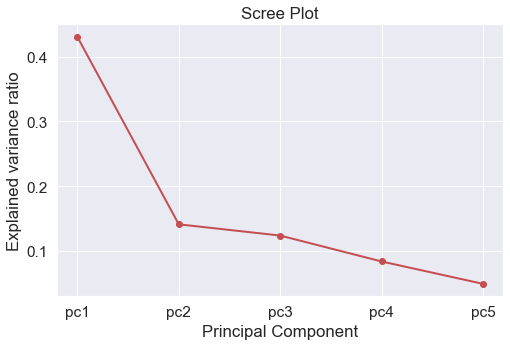



The first four components explan 0.7803 of variance



In [76]:
scaler = StandardScaler()
a = X[['Square', 'LifeSquare', 'Rooms', 'KitchenSquare', 'HouseYear',
       'MedPriceByDistrict', 'MedPriceByEcology_1', 'MedPriceByShops_1',
       'MedPriceBySocial_1','MedPriceBySocial_2', 'MedPriceBySocial_3', 
       'MedPriceByHelthcare_2', 'MedPriceByFloorYear']].fillna(0)
        
a = scaler.fit_transform(a)        
pca = PCA(n_components=5)
pca.fit(a)
print(f'PCA explained variance ratio: {pca.explained_variance_ratio_}\n')

fig = plt.figure(figsize=(8,5))
plt.plot(['pc1','pc2','pc3','pc4', 'pc5'], pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained variance ratio')
plt.show()

print('\n')
print(f'The first four components explan {round(pca.explained_variance_ratio_[:4].sum(),4)} of variance\n')

### 4.1 Analysis of dependence of target on target encoded variables

#### Correlations between the target and each of the target encoded variables

In [77]:
var_list = ['MedPriceByDistrict', 'MedPriceByEcology_1','MedPriceByShops_1',
            'MedPriceBySocial_1', 'MedPriceBySocial_2', 'MedPriceBySocial_3', 
            'MedPriceByHelthcare_2', 'MedPriceByFloorYear', 'DistrictId_count',
            'pca_composit_1', 'pca_composit_2', 'pca_composit_3', 'pca_composit_4']

print('Correlation between log(Price) and target encoded variable:')
for var in var_list:
    corr = np.corrcoef(X[var].fillna(0), np.log(y.Price))[0][1]
    if var[:3] == 'pca':
        print(f'{var}:\t\t {round(corr, 3)}')
    else:
        print(f'{var}:\t {round(corr, 3)}')

Correlation between log(Price) and target encoded variable:
MedPriceByDistrict:	 0.1
MedPriceByEcology_1:	 0.233
MedPriceByShops_1:	 0.579
MedPriceBySocial_1:	 0.464
MedPriceBySocial_2:	 0.185
MedPriceBySocial_3:	 0.37
MedPriceByHelthcare_2:	 0.59
MedPriceByFloorYear:	 0.264
DistrictId_count:	 -0.409
pca_composit_1:		 0.574
pca_composit_2:		 0.317
pca_composit_3:		 -0.048
pca_composit_4:		 -0.201


### 4.2 Correlation matrix of numeric target encoded variables

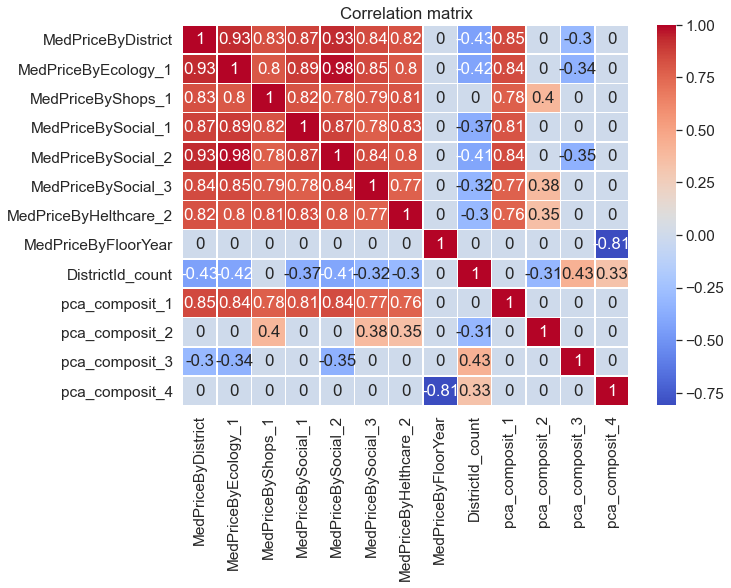

In [78]:
plt.figure(figsize = (10,7))

sns.set(font_scale=1.4)

corr_matrix = X[var_list].corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # Проверьте, что будет если убрать маленькие корреляции

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

#### Normality tests of pca_composit variables and DistrictId_count

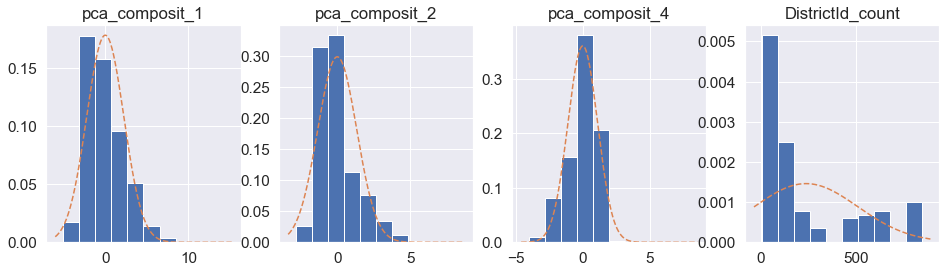

In [79]:
keys = ['pca_composit_1', 'pca_composit_2', 'pca_composit_4', 'DistrictId_count']
norm_test1(X, keys)

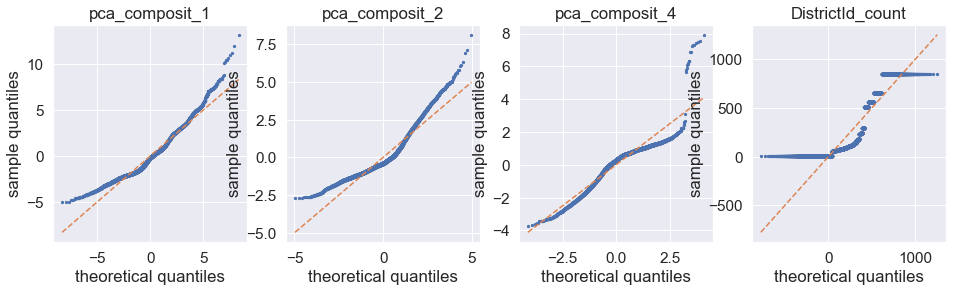

In [80]:
norm_test2(X, keys)

In [81]:
norm_test3(X, keys)

pca_composit_1
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6921
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9592
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9918

pca_composit_2
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7508
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9457
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9882

pca_composit_4
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7313
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9537
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9961

DistrictId_count
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7421
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9149
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		1.0



### 5. Selection of variables for linear regression

Although linear regression is not the best fit for our dataset, to compare the results generated by linear regression vs the ones of non-linear models (LGBMRegressor, RandomForestRegressor, VotingRegressor), here we select variables for linear regression.

Distributions of pca_composit variables are close to normal. 
pca_composit_1, pca_composit_2 and pca_composit_4 have low correlation between each other and acceptable correlation with the target (0.574,0.317 and -0.201 correspondingly). 

Variable DistrictId_count also has acceptable correlation with the target and relatively low correlation with pca_composit variables. But it's distribution is not normal. 

So, the final selection: ['pca_composit_1', 'pca_composit_2', 'pca_composit_4']

In [82]:
var_list = ['pca_composit_1', 'pca_composit_2',  'pca_composit_4']

X_train_linear = np.array(X[var_list].fillna(0))
model = LinearRegression(fit_intercept = True, normalize=True).fit(X_train_linear, np.log(y))

r2 = model.score(X_train_linear, np.log(y.Price))
print(f'The coefficient of determination = {r2}')

n = X.shape[0]
p = len(var_list) + 1
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted coefficient of determination = {r2_adj}')

The coefficient of determination = 0.4705499870531211
Adjusted coefficient of determination = 0.4703381011049683


#### Statistical analysis of the regression equation

In [83]:
k1 = len(var_list)
k2 = n - k1 - 1
F = (r2 / k1) / ((1 - r2) / k2)

alpha = 0.05
t = stats.f.ppf(1 - alpha, k1, k2)
print(f"F-test statistic = {round(F, 3)}, 5% quantile = {round(t, 3)}.")
print('The regression equation is statistically significant')

F-test statistic = 2961.323, 5% quantile = 2.606.
The regression equation is statistically significant


Mean of residuals = -6.732392421326949e-16


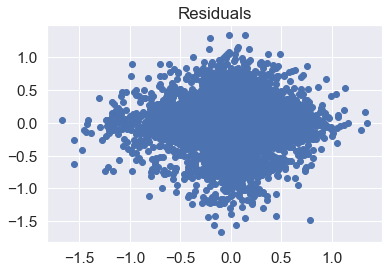

In [84]:
b = model.coef_[0]
y_pred = X_train_linear.dot(b) + model.intercept_

e = np.log(y.Price) - y_pred
print(f'Mean of residuals = {e.mean()}')
plt.scatter(e[1:],e[:-1])
plt.title('Residuals')
plt.show()

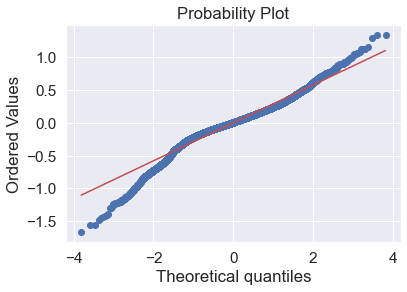

In [85]:
probplot(e, dist="norm", plot=pylab)
pylab.show()

The distribution of residuals departs from normal, so linear regression is not the best fit for our dataset.

Non-linear predictive models are used for Real Estate price prediction in Real_Estate_predicvive_models